# Exercise 8: Supervised Learning

In this exercise a few basic supervised learning pipelines are elaborated.
* Data analysis
* Feature engineering
* Cross-validation
* Regression
  * Linear models and neural networks
* Classification
  * Linear models and neural networks

Moreover, working with the popular __pandas__ library is presented here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
plt.style.use('default')

## a) Data Set

In this exercise we will use a [data set hosted on Kaggle](https://www.kaggle.com/hankelea/system-identification-of-an-electric-motor).
For ease of use and simplicity, we are going to work on a reduced version though, that is provided with this notebook already.

The data set represents lab measurements from a test bench, where a three-phase electric motor was externally speed-controlled while being induced with different voltages, leading to corresponding currents and, thus, torque on the motor. In terms of reinforcement learning the electric motor can be understood as the environment, the observed electrical state of the motor as the state vector and the applied voltages/discrete switching states of the converter as the actions.

### Context
The most important aspect of electric vehicles is their efficiency or achievable range. 
In order to achieve high efficiency, it is essential to avoid the over-dimensioning of the drive train during the design phase.
This can only be achieved if the dynamic behavior of the drive train is accurately known by the controller/agent. 
The task of the controller is to achieve a desired torque at the wheels of the car by controlling the currents of the electric motor.

Control, in this context, is about choosing appropriate, discrete switching states for the transistors in the attached power electronic unit, that affect the voltage applied to the motor.
Knowing which switching state leads to what current change at each point in time helps the controller to choose an appropriate action.
Since in the real world many parasitic, intangible and volatile effects are imposed on currents formation, modeling them statistically is an auspicious endeavor.

### Features

Most of the time, a data set is a table/matrix/2d-tensor with labeled columns (and rows).

Here, rows are consecutively enumerated while columns are the following:

* __n_1k__: elementary vector applied between (k-1) and k. The elementary vector denotes the label-encoded switching state in the converter.
* __id_k__: d-current at k in A (Ampere).
* __iq_k__: q-current at k in A (Ampere). 
* __epsilon_k__: rotor angle at k in rad (Radian).
* __n_k__: elementary vector applied between k and (k+1). 
* __id_k1__: d-current at (k+1) in A (Ampere).
* __iq_k1__: q-current at (k+1) in A (Ampere).

[Read up on d/q-transformation](https://en.wikipedia.org/wiki/Direct-quadrature-zero_transformation) to understand the coordinate notation of the currents (assuming the amplitude-invariant transformation than the power-invariant).

The enlisted features will be utilized for either regression or classification.
Depending on the task, the features denoting input and target quantities will vary, such that the specific mapping will be discussed later.

Lab measurements from a motor are commonly time series data.
Yet, here the records are shuffled, and we only have the link between two elementary vectors (switching states/ actions) in a row itself.

### Optional Literature
If you find the following exercise intriguing and you would like to keep on investigating, have a look at the scientific papers that describe the background to the underlying data set:
* [Part 1](https://arxiv.org/pdf/2003.07273.pdf)
* [Part 2](https://arxiv.org/pdf/2003.06268.pdf)

### Load CSV data set

The pandas library makes reading csv files easy, next to its superb data wrangling utilities. It is also able to read and save archived tabular data as in this exercises' case.

Think of pandas as a layer on top of numpy, that is optimized for tabular data and attaches column/row names to a matrix.

The main pandas class is the so-called _DataFrame_ which holds a table, and the _Series_  that denotes a single column.
Both classes do not only consist of arrays representing the data itself but also of an index (row labeling), that affects basic arithmetic operations between different instantiated objects.

Please refer to the pandas notebooks from exercise 1 for a refresher.

In [2]:
df = pd.read_csv('reduced_emotor.zip')
print(df.shape)
df.head()

(2450000, 7)


,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1
0,-63.43288,222.963500,-1.624982,1,1,-52.36959,217.568600
1,-138.64790,164.999000,-0.499233,1,1,-126.95130,163.001400
2,-162.46010,38.855290,-2.065194,1,1,-156.43410,38.598410
3,-219.68470,0.211794,-2.266253,1,1,-218.79350,0.402872
4,-86.63434,160.142600,-3.091227,1,1,-75.96732,157.305300


### Adding new features
There are two main ways to add further features to the dataframe.

In [3]:
# new feature "pairs"
df = df.assign(pairs=lambda r: r.n_1k.astype(str)+'->'+r.n_k.astype(str))
# alternatively
df['pairs_alternative'] = df.n_1k.astype(str) + '->' + df.n_k.astype(str) 

assert all(df.pairs == df.pairs_alternative)
# remove a feature
del df['pairs_alternative']
# alternatively
# df = df.drop(['pairs_alternative'], axis=1)

In [4]:
df.columns

Index(['id_k', 'iq_k', 'epsilon_k', 'n_k', 'n_1k', 'id_k1', 'iq_k1', 'pairs'], dtype='object')

In [5]:
df.pairs.value_counts().sort_index().head(10)

1->1    50000
1->2    50000
1->3    50000
1->4    50000
1->5    50000
1->6    50000
1->7    50000
2->1    50000
2->2    50000
2->3    50000
Name: pairs, dtype: int64

We recognize, that all transitions within a row appear uniformly throughout the dataset, which is not the case for the original kaggle data but has been intentionally rectified for this exercise's reduced version.

## b) Exploratory Data Analysis

Before any feature engineering should be conducted, it is advisable to investigate the general structure of the data.

This process is called exploratory data analysis (EDA) and usually comprises 
* distribution visualizations, 
* missing data detection, 
* substitution of such, 
* linear correlation analysis,
* time series analysis
* etc.

### Distribution visualizations

In [6]:
def plot_dist(_df):
    fig, axes = plt.subplots(1,2,sharex=True, sharey=True)
    for c, ax in zip(['n_1k', 'n_k'], axes.flatten()):
        sns.countplot(x=c, data=_df,  ax=ax)

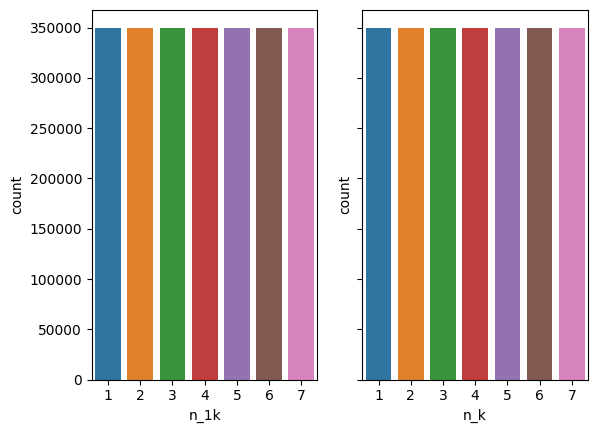

In [7]:
plot_dist(df)

Each elementary vector occurs around 350 thousand times for both, at time _k_ and time _k-1_ .

In the following we plot the distribution of the currents and the motor angle unfolded over each elementary vector.

For this we utilize pandas' _groupby()_ function, which helps to group (and even aggregate) the complete data set with respect to a categorical feature.

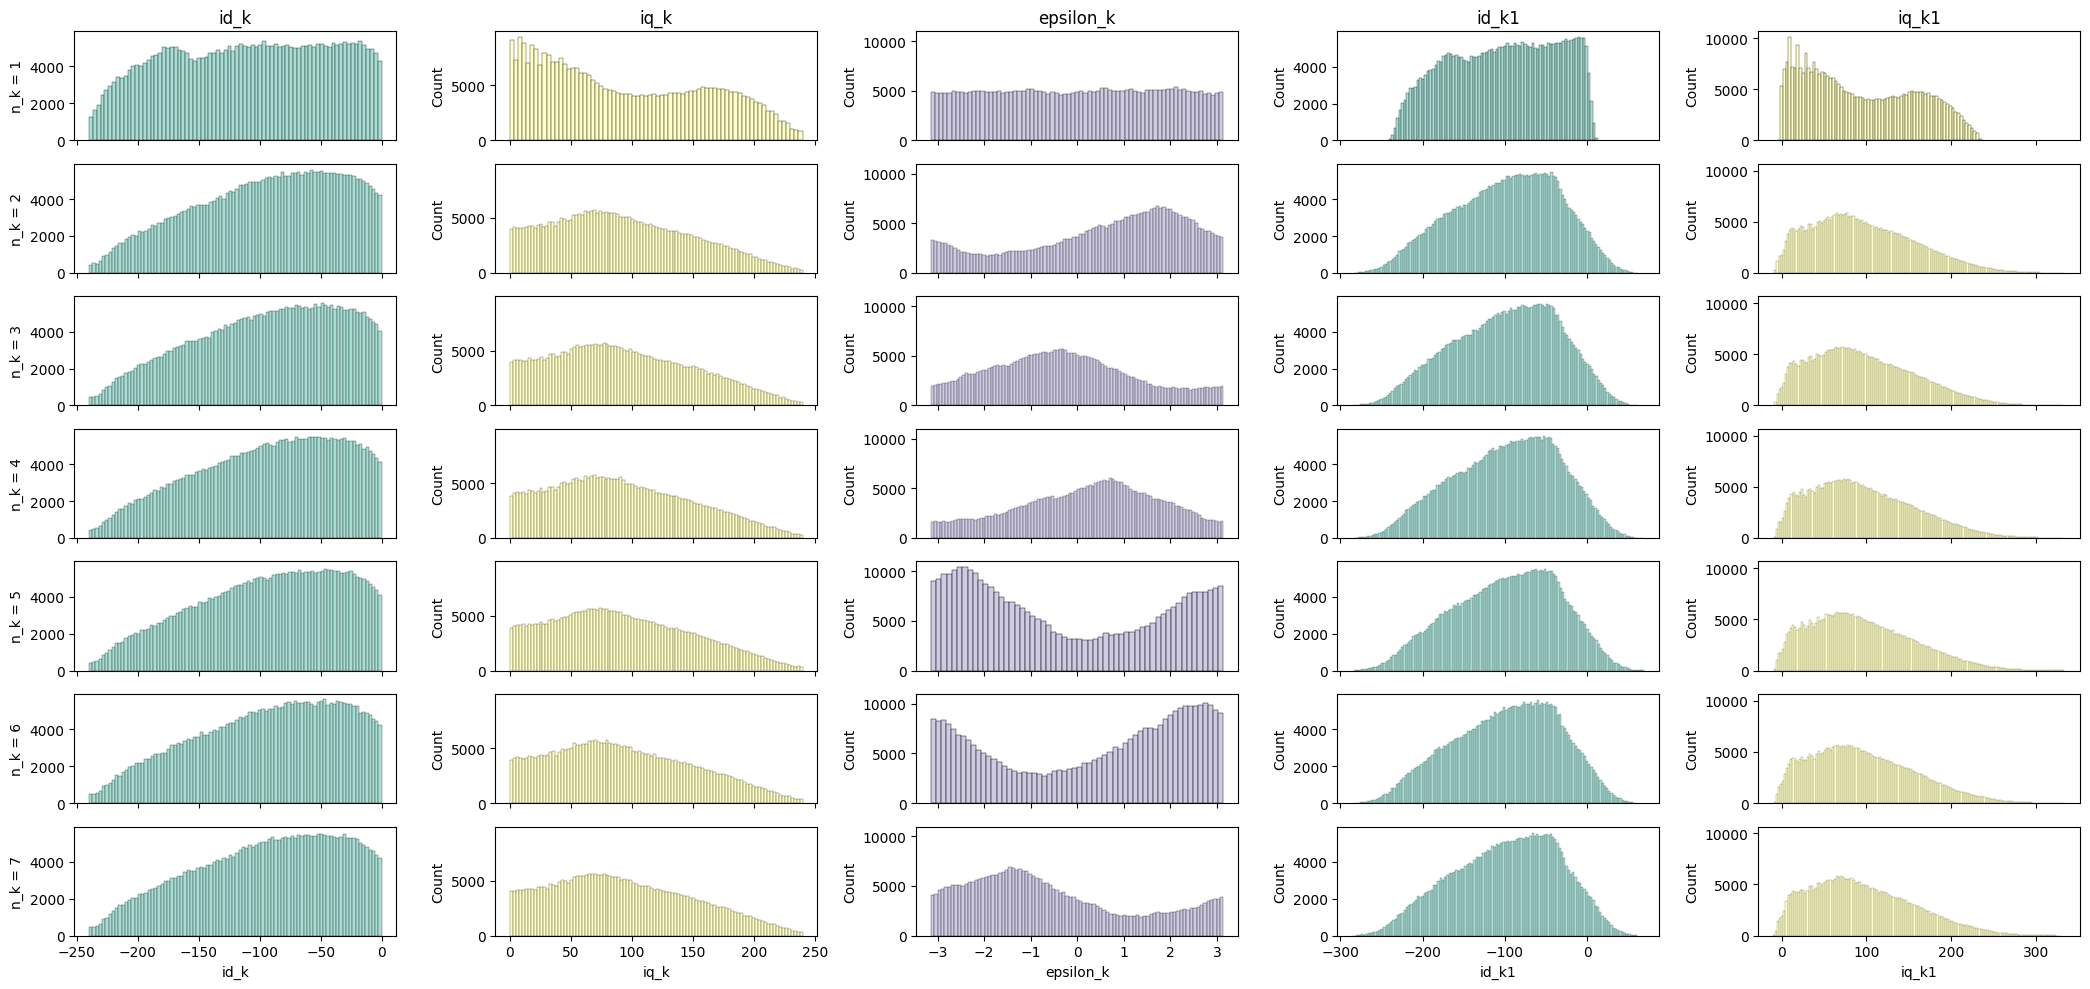

In [8]:
analyzed_cols = [c for c in df if c not in ['n_k', 'n_1k', 'pairs']]

# prepare colors
color_list = plt.cm.Set3(np.linspace(0, 1, 12))
color_d = {'id_k': rgb2hex(color_list[0]),
           'id_k1': rgb2hex(color_list[0]),
           'iq_k': rgb2hex(color_list[1]),
           'iq_k1': rgb2hex(color_list[1]),
           'epsilon_k': rgb2hex(color_list[2])}

def dist_plot(dframe, cols_to_plot):
    unique_elem_vecs = dframe['n_k'].nunique()
    # create plot
    fig, axes = plt.subplots(nrows=unique_elem_vecs, ncols=len(cols_to_plot), 
                             sharex='col', sharey='col', figsize=(3*unique_elem_vecs, 10))
    for k, _df in dframe.groupby('n_k'):
        for i, c in enumerate(cols_to_plot):
            sns.histplot(_df[c], ax=axes[k-1, i], color=color_d.get(c, None))
            if i == 0:
                axes[k-1, i].set_ylabel(f'n_k = {k}')
            if k == 1:
                axes[k-1, i].set_title(c)
            xlbl = c if k == 7 else ''
            axes[k-1, i].set_xlabel(xlbl)

    plt.tight_layout()
dist_plot(df, analyzed_cols)

_(Double-click picture if it appears too small)_.

It seems that _epsilon_k_ exhibits a sine shaped histogram while its range covers $[-\pi, \pi]$.

More subtle, we recognize a semi-sphere shape of the 2d histogram between the currents (remember, d and q currents are to be plotted perpendicular to each other).
It might be auspicious, to add another feature denoting the current vector norm sqrt(id^2 + iq^2).
From the principle of d/q-transformation, we know that the $\ell_2$-norm of the d- and q-current denotes the current amplitude in the system.
From that we recognize, that smaller current magnitudes seem more likely than higher.

#### Task 1: Add features and plot their distributions
* Add sine and cosine of the rotor angle to the dataframe
* Add the current vector norm of both time steps to the dataframe: $i_{norm} = \sqrt{i_d^2 + i_q^2}$
* Plot their distributions

#### Solution 1

In [9]:
df = df.assign(sin_eps_k=lambda df: np.sin(df.epsilon_k), 
               cos_eps_k=lambda df: np.cos(df.epsilon_k),
               i_norm_k=lambda df: np.sqrt(df.id_k**2 + df.iq_k**2),
               i_norm_k1=lambda df: np.sqrt(df.id_k1**2 + df.iq_k1**2))
df.head()

,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1,pairs,sin_eps_k,cos_eps_k,i_norm_k,i_norm_k1
0,-63.43288,222.963500,-1.624982,1,1,-52.36959,217.568600,1->1,-0.998532,-0.054159,231.811243,223.782639
1,-138.64790,164.999000,-0.499233,1,1,-126.95130,163.001400,1->1,-0.478753,0.877950,215.517772,206.606120
2,-162.46010,38.855290,-2.065194,1,1,-156.43410,38.598410,1->1,-0.880255,-0.474502,167.041964,161.125618
3,-219.68470,0.211794,-2.266253,1,1,-218.79350,0.402872,1->1,-0.767761,-0.640736,219.684802,218.793871
4,-86.63434,160.142600,-3.091227,1,1,-75.96732,157.305300,1->1,-0.050344,-0.998732,182.074603,174.688268


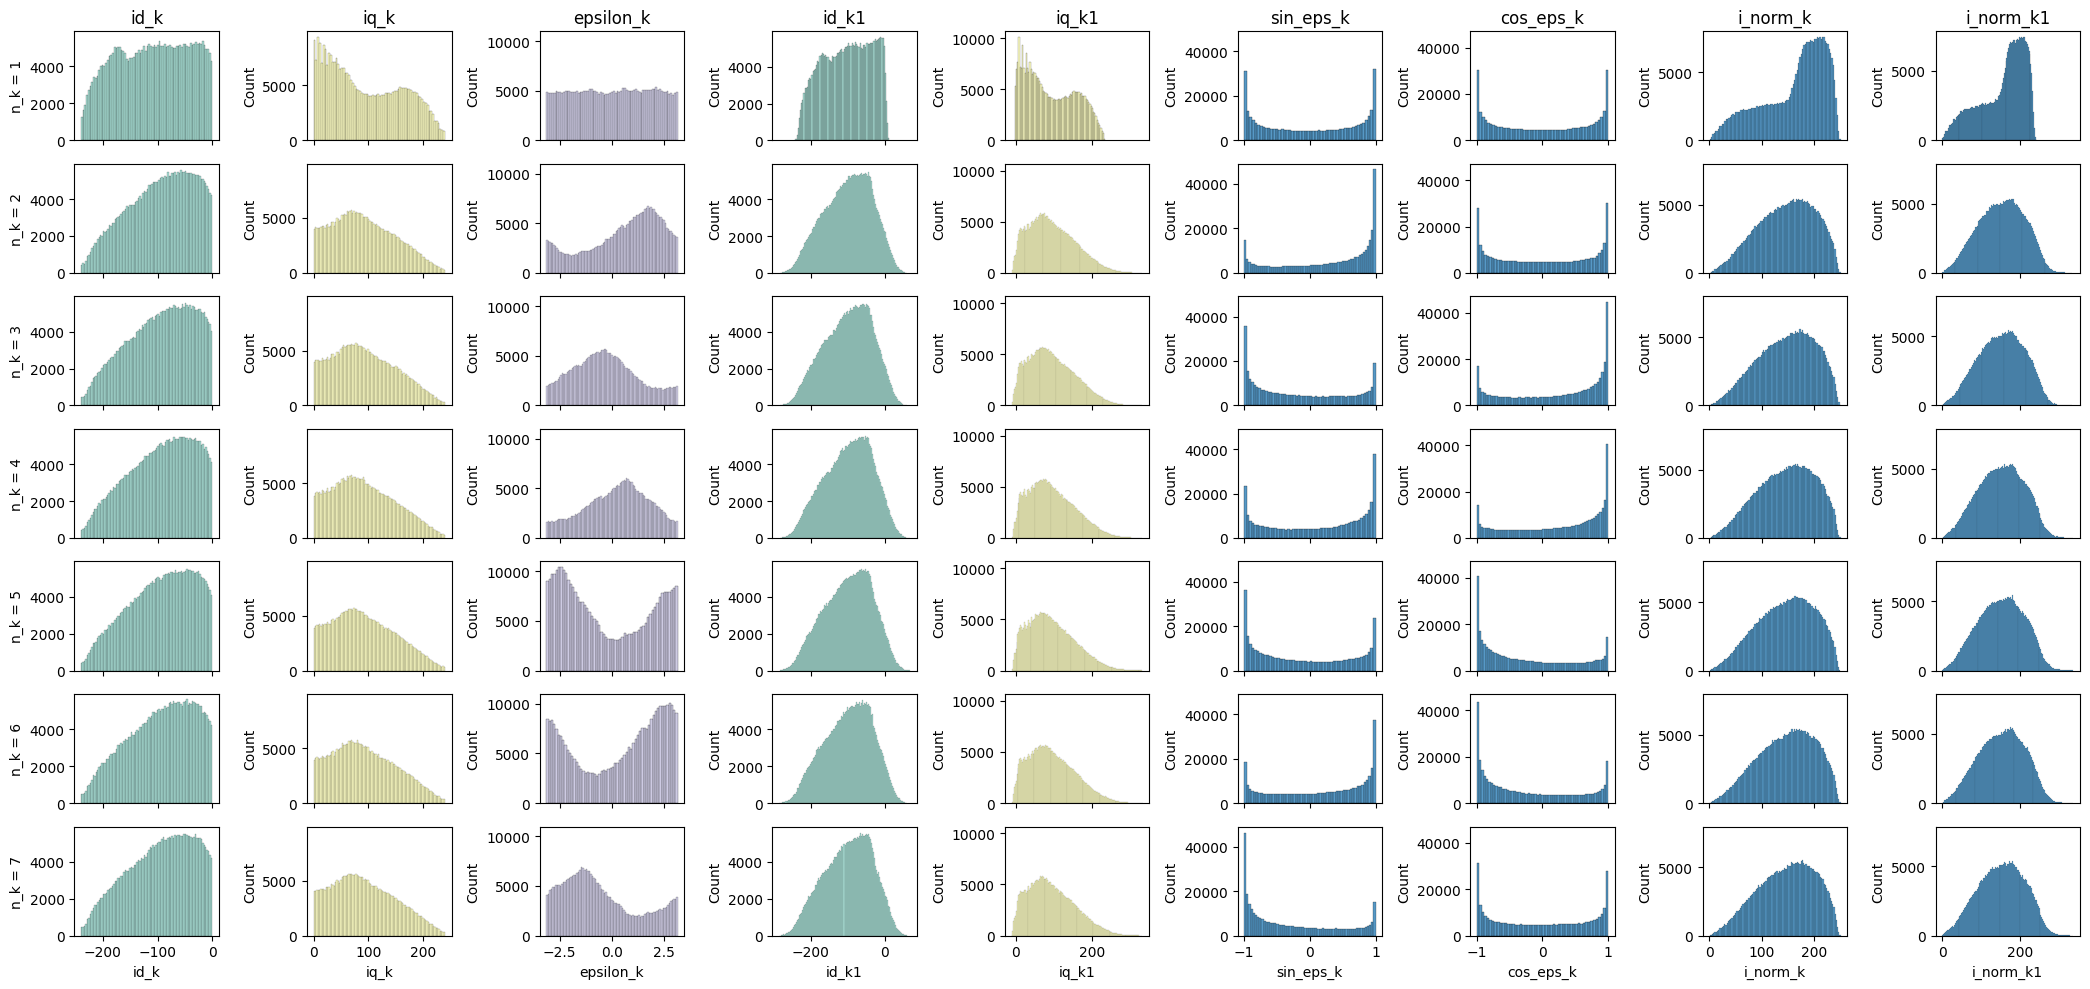

In [10]:
dist_plot(df, [c for c in df if c not in ['n_k', 'n_1k', 'pairs']])

### Scatter plots
Probably, the previous currents are good indicators for the next currents.
Let's visualize this relationship unfold over each transition.

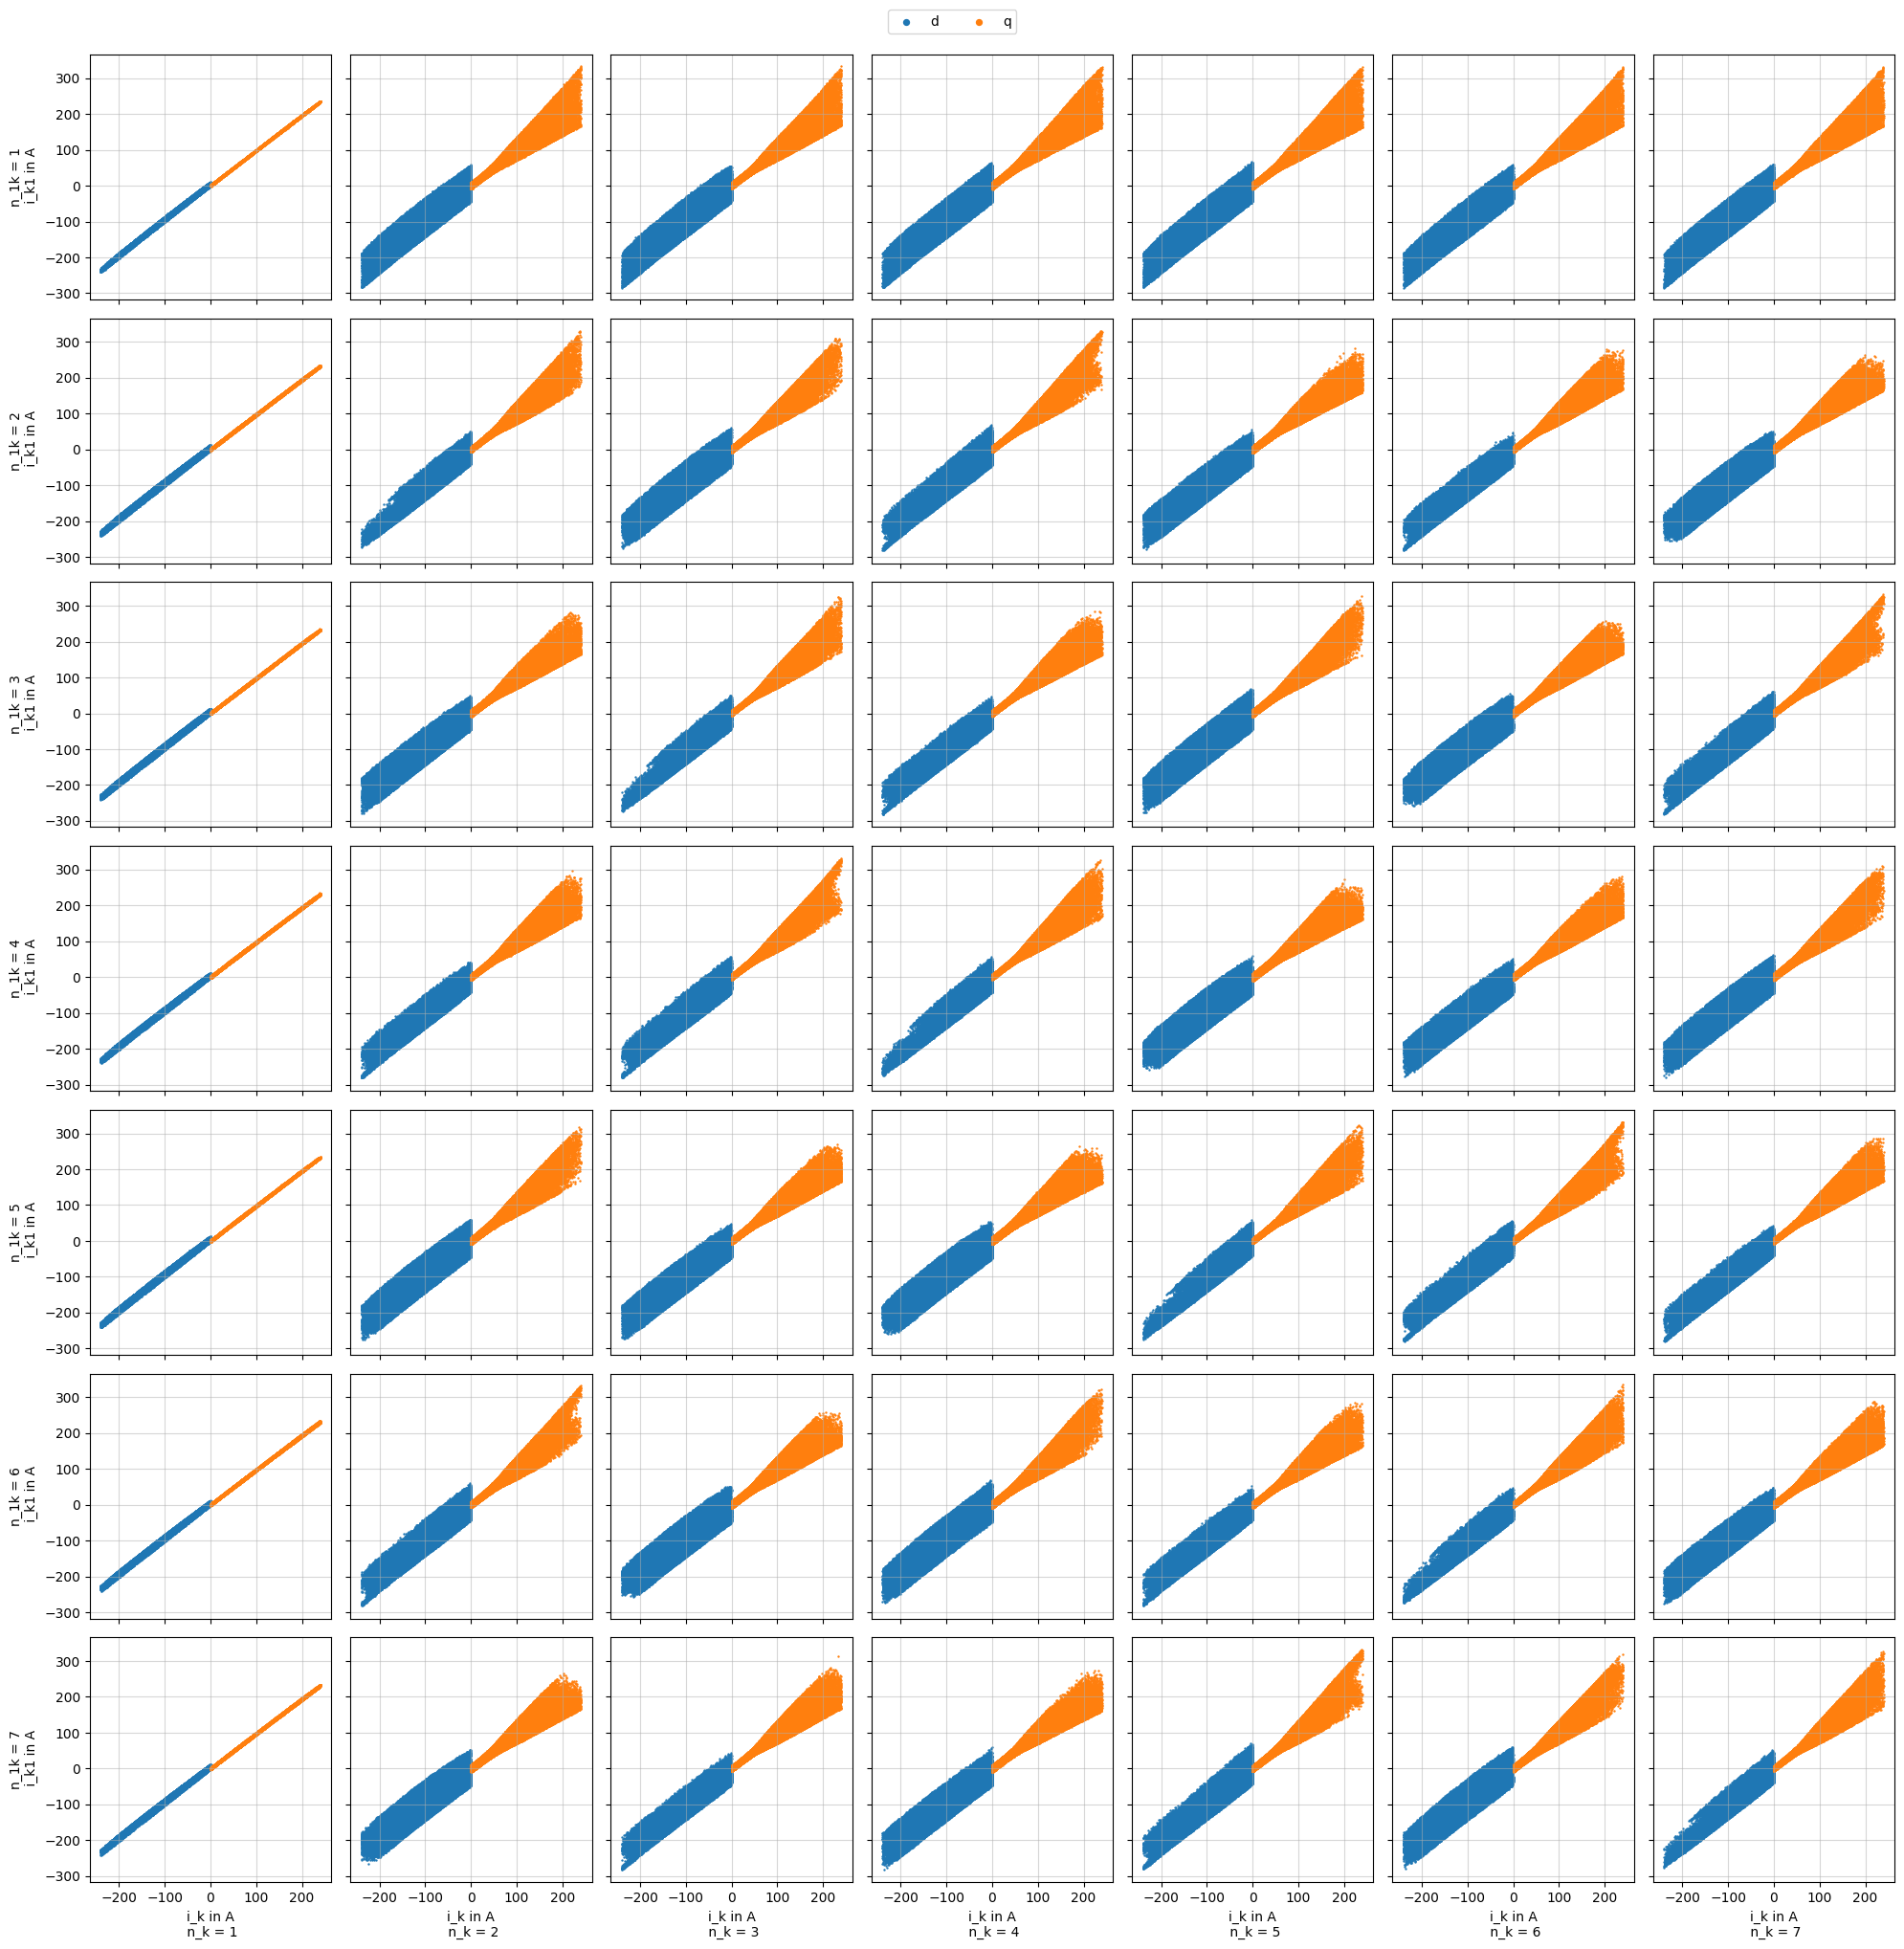

In [11]:
n_cols = 7
n_rows = 7
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, 
                         sharex=True, sharey=True, figsize=(20, 20))
df = df.sort_values(by='pairs')
for ax, (k, _df) in zip(axes.flatten(), df.groupby('pairs')):
    t_prev, t = k.split('->')
    ax.scatter(_df.id_k, _df.id_k1, s=.5, label='d')
    ax.scatter(_df.iq_k, _df.iq_k1, s=.5, label='q')
    if t == '1':
        ax.set_ylabel(f'n_1k = {t_prev}\n i_k1 in A')
    if t_prev == '7':
        ax.set_xlabel(f'i_k in A\n n_k = {t}')
    ax.grid(alpha=.5)
plt.tight_layout()

ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure, markerscale=6)

Apparently, transitions to switching_state == 1 come with far less scatter than for other switching states.
Beyond this, the overall scatter seems relatively linear.

We investigate this by a linear correlation heat map.

### Linear Correlation
The [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) indicates the strength of the linear correlation between two random variables.

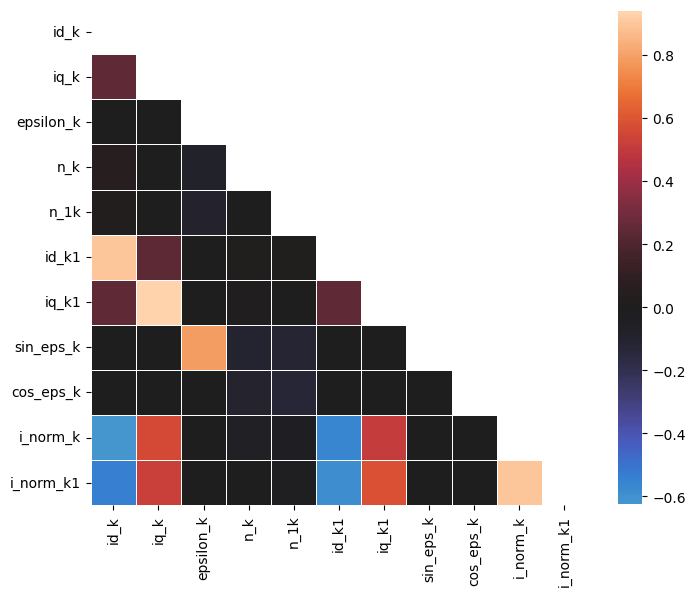

In [12]:
corr = df.drop(['pairs'], axis=1).corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8,8))
_ = sns.heatmap(corr, mask=mask, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8})

It becomes obvious, that features from previous time steps exhibit the strongest linear correlation with those of the actual time step.

This suggests a strong timely dependency, currents follow a [non-stationary process](https://en.wikipedia.org/wiki/Stationary_process).

It is very likely, that more history information for each point in time would reveal precious patterns for an exact forecast of the currents, but these are not available here.

## c) Cross Validation

Before we start modeling, we need to agree on a certain cross-validation (CV) technique.
We will choose a method from scikit-learn.

Please install it with
```
pip install scikit-learn
```

Since distribution of elementary vectors is rather balanced, we will go with a simple CV: 5-Fold CV.

Recall from the lecture what K-Fold CV stands for.

![](./kfold-cv.png)

In [13]:
from sklearn.model_selection import KFold

In [14]:
kf = KFold(n_splits=5, shuffle=True)

## d) Regression

We start off with a regression example: Given the data set, predict the future currents at any time.

### Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse


# more feature engineering
enriched_df = df.assign(# The following are non-task-specific featurs
                        id_k_sqrd=lambda x: x.id_k**2,
                        iq_k_sqrd=lambda x: x.iq_k**2,
                        iq_x_id_k=lambda x: x.id_k*x.iq_k,
                        i_norm_sqrd=lambda x: x.i_norm_k**2,
                        id_k_log=lambda x: np.log1p(x.id_k.abs()),
                        iq_k_log=lambda x: np.log1p(x.iq_k),
                        id_k_exp=lambda x: np.exp(-x.id_k.abs()),
                        iq_k_exp=lambda x: np.exp(-x.iq_k.abs()),
                        i_norm_log=lambda x: np.log1p(x.i_norm_k),
                        i_norm_exp=lambda x: np.exp(x.i_norm_k.abs()),
                        id_plus_iq=lambda x: x.id_k+x.iq_k,
                        id_minus_iq=lambda x: x.id_k-x.iq_k,
                        id_over_iq=lambda x: x.id_k/ (x.iq_k + 1),
                        iq_over_id=lambda x: x.iq_k/ (x.id_k - 1),
    
                        # The following features encompass the whole data set. Is this problematic?
                        #id_pairgroup_normed=lambda x: x.id_k - df.groupby('pairs')['id_k'].transform('mean'),
                        #iq_pairgroup_normed=lambda x: x.iq_k - df.groupby('pairs')['iq_k'].transform('mean'),
                        #id_ngroup_normed=lambda x: x.id_k - df.groupby('n_k')['id_k'].transform('mean'),
                        #iq_ngroup_normed=lambda x: x.iq_k - df.groupby('n_k')['iq_k'].transform('mean'),
    
                        # The following are features taken from https://ieeexplore.ieee.org/document/9545442
                        # You can try them for your neural network training. They should significantly boost performance
                        id_k_cos=lambda x : x.id_k * x.cos_eps_k,
                        iq_k_cos=lambda x : x.iq_k * x.cos_eps_k,
                        id_k_sin=lambda x : x.id_k * x.sin_eps_k,
                        iq_k_sin=lambda x : x.iq_k * x.sin_eps_k,
                        id_k_sqrd_sin=lambda x : x.id_k_sqrd * x.sin_eps_k,
                        iq_k_sqrd_sin=lambda x : x.iq_k_sqrd * x.sin_eps_k,
                        id_k_sqrd_cos=lambda x : x.id_k_sqrd * x.cos_eps_k,
                        iq_k_sqrd_cos=lambda x : x.iq_k_sqrd * x.cos_eps_k,
                        iq_x_id_k_cos=lambda x : x.iq_x_id_k * x.cos_eps_k,
                        iq_x_id_k_sin=lambda x : x.iq_x_id_k * x.sin_eps_k,
                        sin_2eps_k=lambda x : np.sin(2*df.epsilon_k), 
                        cos_2eps_k=lambda x : np.cos(2*df.epsilon_k), 
                        id_k_sin_2eps_k=lambda x : x.id_k * x.sin_2eps_k, 
                        id_k_cos_2eps_k=lambda x : x.id_k * x.cos_2eps_k, 
                        iq_k_sin_2eps_k=lambda x : x.iq_k * x.sin_2eps_k, 
                        iq_k_cos_2eps_k=lambda x : x.iq_k * x.cos_2eps_k, 
                      )

y_cols = ['id_k1', 'iq_k1', 'i_norm_k1']
x_cols = [c for c in enriched_df if c not in y_cols + ['pairs'] ]

for i, (train_index, test_index) in enumerate(kf.split(enriched_df)):
    x_train, y_train = enriched_df.loc[train_index, x_cols], enriched_df.loc[train_index, y_cols]
    x_test, y_test = enriched_df.loc[test_index, x_cols], enriched_df.loc[test_index, y_cols].values
    
    # feature aggregations over the training set
    model = LinearRegression()

    model.fit(x_train, y_train)
    prediction = model.predict(x_test)

    result_string = ', '.join(f'{y_cols[j]}: {mse(y_test[:, j], prediction[:, j]):.2f} A²' for j in range(len(y_cols)))
    print(f'Fold {i}: \nMSE:\t', result_string)

Fold 0: 
MSE:	 id_k1: 4107.52 A², iq_k1: 3705.45 A², i_norm_k1: 3338.23 A²
Fold 1: 
MSE:	 id_k1: 4123.77 A², iq_k1: 3705.33 A², i_norm_k1: 3340.17 A²
Fold 2: 
MSE:	 id_k1: 4113.75 A², iq_k1: 3715.41 A², i_norm_k1: 3341.22 A²
Fold 3: 
MSE:	 id_k1: 4111.56 A², iq_k1: 3712.13 A², i_norm_k1: 3346.77 A²
Fold 4: 
MSE:	 id_k1: 4123.77 A², iq_k1: 3710.66 A², i_norm_k1: 3342.35 A²


The error is homogenous across folds, which affirms our CV strategy.

However, the estimation error is fairly large.

#### Task 2: What did we miss to do before fitting the linear model?
Two important preprocessing steps were missed before conducting model training.
Which might they be? It has something to do with categorical values and value ranges.

In the following, rectify this blunder, and prepare the data appropriately.
* Conduct the CV again.
* Plot the estimation error of the last fold over the corresponding ground truth.

Can you think of more features? Do you think there might be a problem with those features that were aggregated over the full data set in the beginning?

#### Solution 2:

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# one-hot-encode categoricals
ohe_df = enriched_df.assign(**{**{f'n_k_{i}': (enriched_df.n_k == i).astype(int) for i in range(1, 8)},
                               **{f'n_1k_{i}': (enriched_df.n_1k == i).astype(int) for i in range(1, 8)}})\
                        .drop(['n_k', 'n_1k', 'pairs'], axis=1)



y_cols = ['id_k1', 'iq_k1', 'i_norm_k1']
x_cols = [c for c in ohe_df if c not in y_cols]


x_cols_to_scale = [c for c in x_cols if not c.startswith(('n_k', 'n_1k'))]

for i, (train_index, test_index) in enumerate(kf.split(ohe_df)):
        train_set = ohe_df.loc[train_index, :]
        test_set = ohe_df.loc[test_index, :]
        
        # scale
        x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
        x_train = train_set.loc[:, x_cols]
        x_train.loc[:, x_cols_to_scale] = x_scaler.fit_transform(x_train.loc[:, x_cols_to_scale])
        y_train = y_scaler.fit_transform(train_set.loc[:, y_cols])
        x_test = test_set.loc[:, x_cols]
        x_test.loc[:, x_cols_to_scale] = x_scaler.transform(x_test.loc[:, x_cols_to_scale])
        y_test = test_set.loc[:, y_cols].values
        
        # validate
        model = LinearRegression()
        model.fit(x_train, y_train)
        prediction = model.predict(x_test)
        prediction = y_scaler.inverse_transform(prediction)
        
        result_string = ', '.join(f'{y_cols[j]}: {mse(y_test[:, j], prediction[:, j]):.2f} A²' 
                                  for j in range(len(y_cols)))
        print(f'Fold {i}: \nMSE:\t', result_string)

Fold 0: 
MSE:	 id_k1: 785.66 A², iq_k1: 418.59 A², i_norm_k1: 645.63 A²
Fold 1: 
MSE:	 id_k1: 787.17 A², iq_k1: 419.82 A², i_norm_k1: 646.26 A²
Fold 2: 
MSE:	 id_k1: 787.96 A², iq_k1: 419.50 A², i_norm_k1: 647.98 A²
Fold 3: 
MSE:	 id_k1: 789.32 A², iq_k1: 420.48 A², i_norm_k1: 649.56 A²
Fold 4: 
MSE:	 id_k1: 787.19 A², iq_k1: 418.68 A², i_norm_k1: 647.54 A²


### Residuals

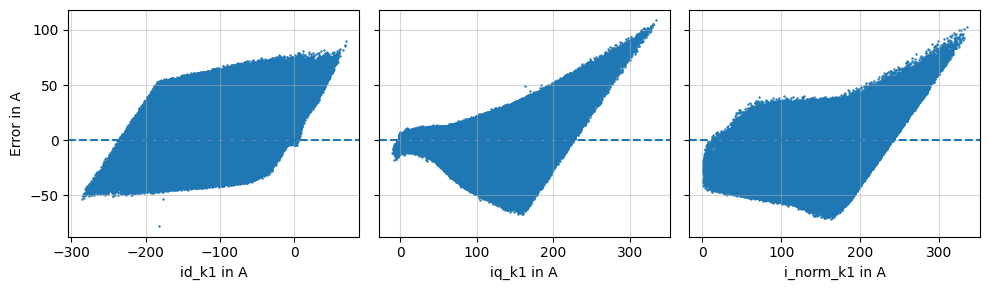

In [17]:
# residuals
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey='row')
error = y_test - prediction

for i in range(len(y_cols)):
    axes[i].scatter(y_test[:, i], error[:, i], s=.5, label=y_cols[i])
    axes[i].grid(alpha=.5)
    axes[i].axhline(ls='--')
    if i == 0:
        axes[i].set_ylabel('Error in A')
    axes[i].set_xlabel(y_cols[i]+' in A')
fig.tight_layout()

The residuals show strong geometrical shapes along the ground truth. Hence, systematic errors are still included.

## e) Neural Networks

In the following, we showcase how a neural network can be trained to solve the aforementioned prediction problem.

Is a neural network better?

Be aware that training time of a neural network is substantially longer than for linear models. If you face out-of-memory errors, please reduce the n_units parameter, the batch_size parameter, or subsample the data set.


#### Bonus task: Try to tweak the hyperparameters of the NN in order to achieve a better performance.

If you find a decent setting, you are invited to post your solution to [kaggle kernels](https://www.kaggle.com/hankelea/system-identification-of-an-electric-motor/kernels). Don't be shy!

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

In [19]:
class FeedForwardNetwork(nn.Module):
    """Example definition for a very basic feed forward neural network."""

    def __init__(self, input_dim):
        """Initialization function for the network.
        
        This function stacks multiple modules back to back to form a layer stack. The 
        output of each module is used as the input to the next module.
        """
        super(FeedForwardNetwork, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        """Forward pass through the network.

        Two things happen here simultaneously:
         1. The input x is passed through all modules in the layer stack to compute the
             output of the network.
         2. The operations gradient functions are stored in a computational graph to
             compute the gradient of output w.r.t. the parameters of the network in
             the backward pass.
    
        https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#more-on-computational-graphs
        """
        return self.layer_stack(x)

In [20]:
def prepare_data(train_set, test_set, y_cols, x_cols, x_cols_to_scale):
    """Scales the data and converts it to torch tensors."""
    
    x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
    x_train = train_set.loc[:, x_cols]
    x_train.loc[:, x_cols_to_scale] = x_scaler.fit_transform(x_train.loc[:, x_cols_to_scale])

    y_train = y_scaler.fit_transform(train_set.loc[:, y_cols])
    x_test = test_set.loc[:, x_cols]
    x_test.loc[:, x_cols_to_scale] = x_scaler.transform(x_test.loc[:, x_cols_to_scale])
    y_test = test_set.loc[:, y_cols].values

    # Convert to PyTorch tensors
    x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)

    return x_train_tensor, y_train_tensor, x_test_tensor, y_test, y_scaler

def learn(model, x_batch, y_batch, criterion, optimizer):
    """Computes the model estimate, compares it to the ground-truth 
    and performs the parameter update.
    """
    optimizer.zero_grad() 
    output = model(x_batch)  # forward pass through the model
    loss = criterion(output, y_batch)
    loss.backward()  # backward step to compute gradients
    optimizer.step()  # optimizer uses gradient for parameter update

    return loss.item()

In [21]:
input_dim = x_train.shape[1]
criterion = nn.MSELoss()

# Training parameters
batch_size = 64
epochs = 10

y_cols = ['id_k1', 'iq_k1', 'i_norm_k1']
x_cols = [c for c in ohe_df if c not in y_cols]
x_cols_to_scale = [c for c in x_cols if not c.startswith(('n_k', 'n_1k'))]

for i, (train_index, test_index) in enumerate(kf.split(ohe_df)):
    # Initialize model and optimizer inside loop
    model = FeedForwardNetwork(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)

    # Train-test split
    train_set = ohe_df.loc[train_index, :]
    test_set = ohe_df.loc[test_index, :]
    
    x_train_tensor, y_train_tensor, x_test_tensor, y_test, y_scaler = prepare_data(
        train_set, test_set, y_cols, x_cols, x_cols_to_scale
    )

    # DataLoader
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    model.train()
    for epoch in range(epochs):
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for x_batch, y_batch in progress_bar:
            loss = learn(model, x_batch, y_batch, criterion, optimizer)
            progress_bar.set_postfix(loss=loss)
    
    # Prediction
    model.eval()
    with torch.no_grad():
        prediction = model(x_test_tensor)
        prediction = y_scaler.inverse_transform(prediction.numpy())
        print(f"MSE: id_k1: {criterion(torch.tensor(prediction[:,0]), torch.tensor(y_test[:,0])):.2f} A²,\
              iq_k1: {criterion(torch.tensor(prediction[:,1]), torch.tensor(y_test[:,1])):.2f} A²,\
              i_norm_k1: {criterion(torch.tensor(prediction[:,2]), torch.tensor(y_test[:,2])):.2f} A²")


Epoch 1/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/30625 [00:00<?, ?it/s]

MSE: id_k1: 4.57 A²,              iq_k1: 5.50 A²,              i_norm_k1: 6.23 A²


Epoch 1/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/30625 [00:00<?, ?it/s]

MSE: id_k1: 4.95 A²,              iq_k1: 5.46 A²,              i_norm_k1: 6.15 A²


Epoch 1/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/30625 [00:00<?, ?it/s]

MSE: id_k1: 4.73 A²,              iq_k1: 6.18 A²,              i_norm_k1: 6.07 A²


Epoch 1/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/30625 [00:00<?, ?it/s]

MSE: id_k1: 4.71 A²,              iq_k1: 5.39 A²,              i_norm_k1: 6.67 A²


Epoch 1/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/30625 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/30625 [00:00<?, ?it/s]

MSE: id_k1: 5.06 A²,              iq_k1: 6.99 A²,              i_norm_k1: 7.84 A²


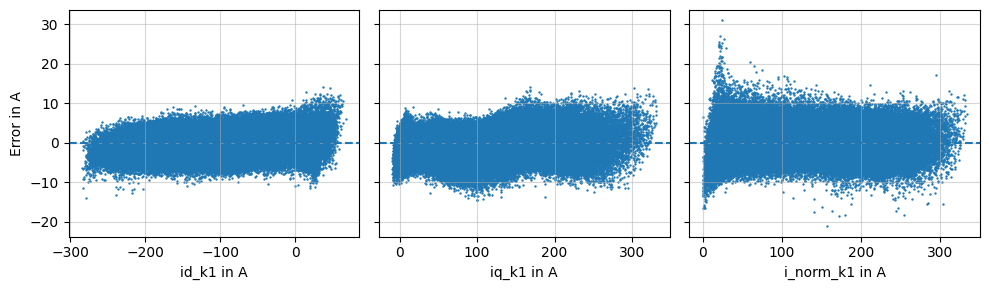

In [22]:
# Residuals
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharey='row')
error = y_test - prediction

for i in range(len(y_cols)):
    axes[i].scatter(y_test[:, i], error[:, i], s=.5, label=y_cols[i])
    axes[i].grid(alpha=.5)
    axes[i].axhline(ls='--')
    if i == 0:
        axes[i].set_ylabel('Error in A')
    axes[i].set_xlabel(y_cols[i]+' in A')
fig.tight_layout()